# Zillow Clustering Project Scratchpad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
from env import host, user, password
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import acquire
import prepare
import explore
import warnings
warnings.filterwarnings('ignore')

In [2]:
# connect to database, perform SQL query, write to csv, and convert to pandas DataFrame
df = acquire.get_zillow_cluster()

In [3]:
# what are we starting with?
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52438 entries, 0 to 52437
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52438 non-null  float64
 3   heatingorsystemtypeid         33934 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13638 non-null  float64
 7   parcelid                      52438 non-null  int64  
 8   id                            52438 non-null  int64  
 9   basementsqft                  47 non-null     float64
 10  bathroomcnt                   52438 non-null  float64
 11  bedroomcnt                    52438 non-null  float64
 12  buildingqualitytypeid         33739 non-null  float64
 13  c

#### Data Preparation To Do List:
- Set parcelid as index
- Drop Columns that have more than 50% null values
- Drop Rows that have more than 75% null values
- Encode or Drop Object Columns
- Create New Variable Columns for:
    - age of property
    - convert lot size to acres
    - bath:bed ratio
    - taxrate
- Other Columns to Drop:

In [4]:
# rename parcelid as parcel_id and set as index

df = prepare.new_index(df)
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,bathroomcnt,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
parcel_id,,,,,,,,,,,,,,,,,,,,,
14297519,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1727539,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
17052889,NaN,NaN,261.0,NaN,NaN,NaN,NaN,1387261,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
14186244,NaN,NaN,261.0,NaN,NaN,NaN,NaN,11677,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
12177905,NaN,NaN,261.0,2.0,NaN,NaN,NaN,2288172,NaN,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
12095076,NaN,NaN,261.0,2.0,NaN,NaN,1.0,781532,NaN,3.0,...,6.037461e+13,-0.001011,2017-01-01,Central,NaN,NaN,Central,Single Family Residential,NaN,NaN


In [5]:
# uses my nulls_by_col function and drops all columns with 50% or more null values
# uses my nulls_by_row function and drops all rows with 75% or more null values
df = prepare.handle_missing_values(df)

In [6]:
# creates dummy columns for each county
df = prepare.get_counties(df)

In [7]:
# creates my desired new feature columns
df = prepare.create_features(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52359 entries, 14297519 to 12826780
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         52359 non-null  float64
 1   heatingorsystemtypeid         33934 non-null  float64
 2   id                            52359 non-null  int64  
 3   bathroomcnt                   52359 non-null  float64
 4   bedroomcnt                    52359 non-null  float64
 5   buildingqualitytypeid         33738 non-null  float64
 6   calculatedbathnbr             52297 non-null  float64
 7   calculatedfinishedsquarefeet  52351 non-null  float64
 8   finishedsquarefeet12          52187 non-null  float64
 9   fips                          52359 non-null  float64
 10  fullbathcnt                   52297 non-null  float64
 11  latitude                      52359 non-null  float64
 12  longitude                     52359 non-null  floa

In [9]:
df['heatingorsystemtypeid'].value_counts()

2.0     20736
7.0     12564
6.0       517
20.0       85
13.0       16
1.0         7
18.0        6
10.0        2
24.0        1
Name: heatingorsystemtypeid, dtype: int64

In [10]:
df = prepare.drop_columns(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52359 entries, 14297519 to 12826780
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   52359 non-null  float64
 1   bedroomcnt                    52359 non-null  float64
 2   calculatedbathnbr             52297 non-null  float64
 3   calculatedfinishedsquarefeet  52351 non-null  float64
 4   fips                          52359 non-null  float64
 5   fullbathcnt                   52297 non-null  float64
 6   latitude                      52359 non-null  float64
 7   longitude                     52359 non-null  float64
 8   lotsizesquarefeet             51999 non-null  float64
 9   rawcensustractandblock        52359 non-null  float64
 10  roomcnt                       52359 non-null  float64
 11  yearbuilt                     52317 non-null  float64
 12  structuretaxvaluedollarcnt    52285 non-null  floa

ValueError: supplied range of [-119475416.0, inf] is not finite

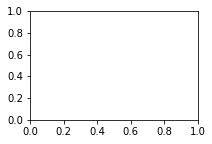

In [12]:
explore.plot_variable_dist(df)

In [ ]:
plot_variable_dist(df)

In [ ]:
# What about outliers...
cols = ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxrate', 'acres', 'bath_bed_ratio']

df = prepare.drop_outliers(df, cols, k=3)